## 1. Tiền xử lý dữ liệu

In [1]:
import numpy as np
import pandas as pd
from pyvi import ViTokenizer

text = content = open("data/truyen_kieu_data.txt", "r", encoding="utf-8").read()

### Loại bỏ dấu câu

In [3]:
def loai_bo_dau_cau(text):
    dau_cau = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for p in dau_cau:
        text = text.replace(p, '')
    return text

### Tạo bộ từ vựng

In [4]:
def tao_vocab(text):
    unique_words = list(set(text))
    vocab = pd.DataFrame({
        'word': unique_words,
        'index': range(len(unique_words))
    })
    return vocab

### Tiền xử lý dữ liệu

In [5]:
def tien_xu_ly(text):
    text = text.lower()
    text = loai_bo_dau_cau(text)
    text = ViTokenizer.tokenize(text)
    text = text.split()
    stopwords = [
    "là", "và", "của", "có", "cho", "với", "một", "được", "này", "như",
    "cũng", "nhưng", "rằng", "trong", "khi", "đã", "đang", "tôi", "chúng", "bạn",
    "vì", "thì", "sẽ", "thế", "nên", "điều", "đây", "đó", "nào", "thôi"
    ]
    text = [word for word in text if word.lower() not in stopwords]
    text
    vocabulary = tao_vocab(text)
    return text, vocabulary

## 2. Thiết kế mô hình skip-gram

In [6]:
# def one_hot(words, word_to_index):
#     one_hot_matrix = np.zeros((len(words), len(word_to_index)), dtype=int)
#     for i, word in enumerate(words):
#         index = word_to_index[word]
#         one_hot_matrix[i, index] = 1
#     return one_hot_matrix

In [7]:
def one_hot(context_words, word_to_index):
    y_true = np.zeros(len(word_to_index))
    for word in context_words:
        y_true[word_to_index[word]] = 1
    return y_true

In [8]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

## 3. Huấn luyện mô hình

In [9]:
EPOCHS = 25
LEARNING_RATE = 0.01
WINDOW_SIZE = 2

### center_word, contex_word

In [10]:
def tao_cap_skipgram(words, window_size=WINDOW_SIZE):
    pairs = []
    for i in range(len(words)):
        for neighbor in range(1, window_size + 1):
            if i - neighbor >= 0:
                pairs.append((words[i], words[i - neighbor]))
            if i + neighbor < len(words):
                pairs.append((words[i], words[i + neighbor]))
    return pairs

### Foward pass

In [11]:
# def forward_pass(center_word_index, context_word_index, embedding_matrix, output_matrix):
#     center_vector = embedding_matrix[center_word_index]
    
#     logits = np.dot(center_vector, output_matrix)
    
#     softmax_output = softmax(logits)
    
#     loss = -np.log(softmax_output[context_word_index])
    
#     return loss, softmax_output


In [12]:
def forward(center_word, context_words, W_in, W_out, word_to_index):
    center_idx = word_to_index[center_word]
    h = W_in[center_idx]
    u = W_out.T @ h
    y_pred = softmax(u)
    y_true = one_hot(context_words, word_to_index)
    loss = -np.sum(y_true * np.log(y_pred + 1e-9))
    return y_pred, loss, h, y_true

### Backward pass

In [13]:
# def backward_pass(center_word_index, context_word_index, softmax_output, embedding_matrix, output_matrix, learning_rate):
#     dL_dsoftmax = softmax_output
#     dL_dsoftmax[context_word_index] -= 1

#     center_vector = embedding_matrix[center_word_index]
#     dL_doutput_matrix = np.outer(center_vector, dL_dsoftmax)
    
#     output_matrix -= learning_rate * dL_doutput_matrix

#     dL_dcenter_vector = np.dot(output_matrix, dL_dsoftmax)
    
#     embedding_matrix[center_word_index] -= learning_rate * dL_dcenter_vector


In [14]:
def backward(h, y_pred, y_true, W_out):
    error = y_pred - y_true
    dW_out = np.outer(h, error)
    dW_in = W_out @ error
    return dW_in, dW_out

### Train model

In [15]:
# def train_skipgram_model(skipgram_pairs, embedding_matrix, output_matrix, 
#                           word_to_index, epochs=EPOCHS, learning_rate=LEARNING_RATE):
#     for epoch in range(epochs):
#         total_loss = 0
#         np.random.shuffle(skipgram_pairs)
        
#         for center_word, context_word in skipgram_pairs:
#             center_index = word_to_index[center_word]
#             context_index = word_to_index[context_word]
            
#             loss, softmax_output = forward_pass(center_index, context_index, embedding_matrix, output_matrix)
#             total_loss += loss
            
#             backward_pass(center_index, context_index, softmax_output, embedding_matrix, output_matrix, learning_rate)
        
#         print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(skipgram_pairs):.4f}")
    
#     return embedding_matrix, output_matrix

In [16]:
def train_skipgram_model(data, word_to_index, W_in, W_out, epochs, learning_rate):
    for epoch in range(epochs):
        total_loss = 0
        for i in range(1, len(data) - 1):
            center_word = data[i]
            context_words = [data[i - 1], data[i + 1]]

            y_pred, loss, h, y_true = forward(center_word, context_words, W_in, W_out, word_to_index)
            total_loss += loss

            dW_in, dW_out = backward(h, y_pred, y_true, W_out)

            center_idx = word_to_index[center_word]
            W_in[center_idx] -= learning_rate * dW_in
            for context_word in context_words:
                context_idx = word_to_index[context_word]
                W_out[:, context_idx] -= learning_rate * dW_out[:, context_idx]

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")
    return W_in, W_out

In [17]:
text, vocab = tien_xu_ly(text)
word_to_index = {row['word']: row['index'] for _, row in vocab.iterrows()}

In [18]:
v = len(vocab)
d = 100
embedding_matrix = np.random.uniform(-0.01, 0.01, (v, d))
output_matrix = np.random.uniform(-0.01, 0.01, (d, v))
# embedding_matrix = np.random.randn(v, d)
# output_matrix = np.random.randn(d, v)
skipgram_pairs = tao_cap_skipgram(text)

In [19]:
embedding_matrix, output_matrix = train_skipgram_model(text, word_to_index, embedding_matrix, output_matrix, EPOCHS, LEARNING_RATE)

Epoch 1/25, Loss: 5486158.0656


KeyboardInterrupt: 

## 4. Đánh giá Embedding Vector

In [137]:
# Kiểm tra kết quả
print("Embedding Matrix:")
print(embedding_matrix)

Embedding Matrix:
[[ 0.01051136  0.022318   -0.07598519 ...  0.02961134 -0.04129483
   0.04176359]
 [-0.01841081 -0.02206998 -0.08811687 ...  0.01887899 -0.01400662
   0.0230541 ]
 [ 0.0522962   0.03982479 -0.09673868 ...  0.05882267 -0.00967069
   0.0669361 ]
 ...
 [-0.01731636  0.00880745 -0.05411551 ...  0.01916937 -0.02533401
   0.0306068 ]
 [-0.00575233  0.01362246 -0.01640403 ...  0.01257925 -0.01576103
   0.01116697]
 [-0.00205587  0.00208222  0.01649265 ... -0.01325731  0.0086061
  -0.01479357]]


In [138]:
word_to_index

{'1235': 0,
 'đến_nỗi': 1,
 'muốn': 2,
 'ruột_rà': 3,
 'dưỡng': 4,
 'vóc_sương': 5,
 'tiểu_kiều': 6,
 'rẻ_rúng': 7,
 'chi_tài': 8,
 'quả_nhiên': 9,
 'ngắm_nghía': 10,
 'thiên': 11,
 'con_trẻ': 12,
 'buông_mành': 13,
 'lấp': 14,
 'co': 15,
 'ghẻ': 16,
 'nghìn_cân': 17,
 '73': 18,
 'tắt': 19,
 'nợ_nần': 20,
 'ầm_ầm': 21,
 'cất': 22,
 'tan_tác': 23,
 'ràng_buộc': 24,
 'chăm_chút': 25,
 '2085': 26,
 '1230': 27,
 'thỉnh': 28,
 'cõi_đời': 29,
 'lòa': 30,
 'đợi': 31,
 'cầu_thân': 32,
 'dạo': 33,
 'ngần_ngừ': 34,
 'dịch': 35,
 'lộc': 36,
 'xe': 37,
 'tự': 38,
 'giếng_khơi': 39,
 '1415': 40,
 'lụy': 41,
 'bia_miệng': 42,
 '1680': 43,
 'cãi': 44,
 'nhất': 45,
 'ưng': 46,
 'trạch': 47,
 'quỳnh': 48,
 'dốn': 49,
 'dây_xích': 50,
 'trước_sau': 51,
 'cười_nụ': 52,
 '735': 53,
 'canh_tàn': 54,
 'vừa': 55,
 'len': 56,
 'khắp': 57,
 '40': 58,
 'bẻ': 59,
 'nhi': 60,
 'bấy': 61,
 '570': 62,
 'bầy': 63,
 '2785': 64,
 '54': 65,
 '1635': 66,
 'tề_chỉnh': 67,
 'êm_ái': 68,
 '905mai': 69,
 'phó_về': 70,
 'đáy

### Cosine Similarity
    [1] https://www.geeksforgeeks.org/how-to-calculate-cosine-similarity-in-python/

In [139]:
from numpy.linalg import norm

def cosine_similarity(vec1, vec2):
    return vec1 @ vec2 / (norm(vec1) * norm(vec2))

In [151]:
# Bộ từ kiểm tra
word_pairs = [
    ("thẹn_thùng", "e_lệ"),
    ("vui", "khóc"), 
    ("máu_ghen", "khát_khao")  
]

print("Cosine similarity:")
for word1, word2 in word_pairs:
    if word1 in word_to_index and word2 in word_to_index:
        vec1 = embedding_matrix[word_to_index[word1]]
        vec2 = embedding_matrix[word_to_index[word2]]
        similarity = cosine_similarity(vec1, vec2)
        print(f"({word1}, {word2}): {similarity:.4f}")
    else:
        print(f"({word1}, {word2}): Một trong hai từ không có trong từ điển.")


Cosine similarity:
(thẹn_thùng, e_lệ): 0.4867
(vui, khóc): -0.0213
(máu_ghen, khát_khao): -0.4317


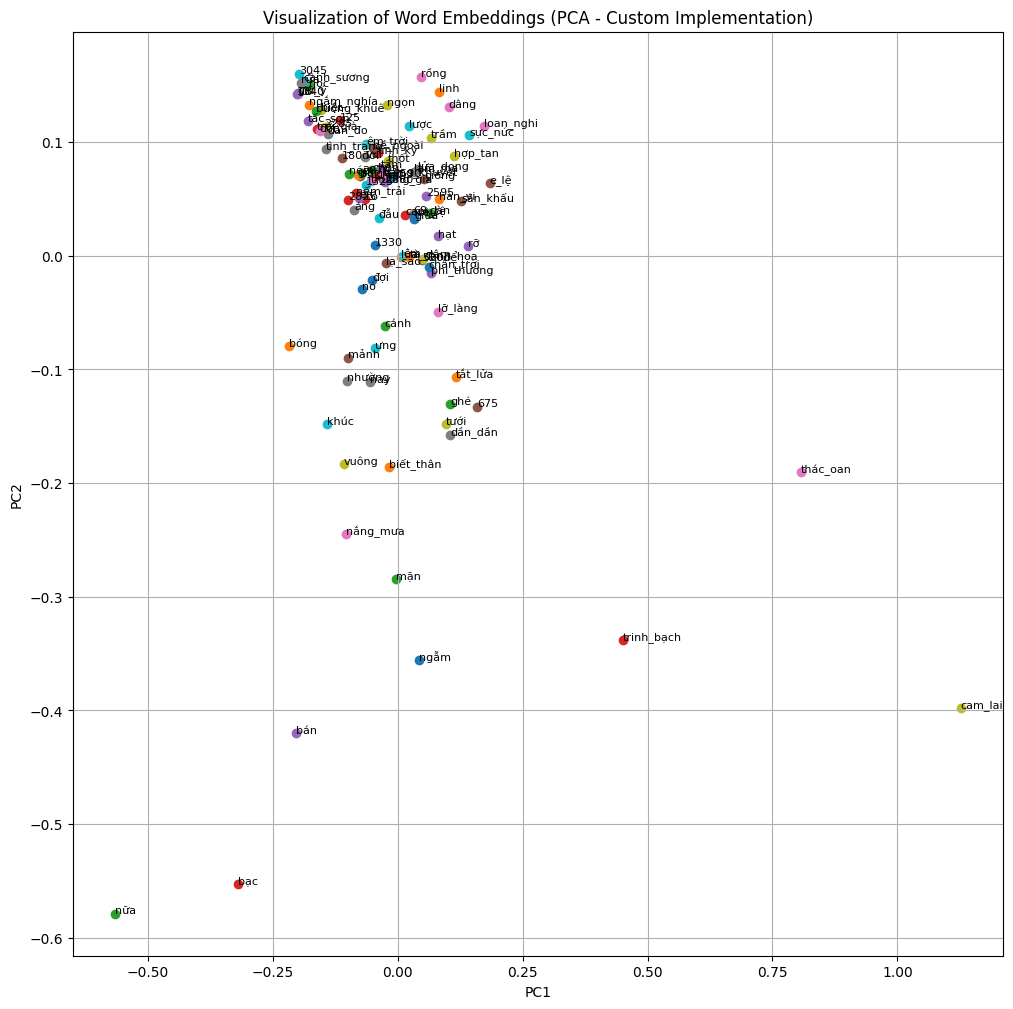

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import random
def pca(data, n_components=2):
    mean = np.mean(data, axis=0)
    data_centered = data - mean
    cov_matrix = np.cov(data_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    principal_components = eigenvectors[:, :n_components]
    reduced_data = np.dot(data_centered, principal_components)
    return reduced_data
reduced_embeddings = pca(embedding_matrix, n_components=2)
num_words_to_plot = 100
selected_words = random.sample(list(word_to_index.items()), num_words_to_plot)
plt.figure(figsize=(12, 12))
for word, index in selected_words:
    plt.scatter(reduced_embeddings[index, 0], reduced_embeddings[index, 1])
    plt.text(reduced_embeddings[index, 0], reduced_embeddings[index, 1], word, fontsize=8)
plt.title("Visualization of Word Embeddings (PCA - Custom Implementation)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [142]:
def predict_context_words(center_word, word_to_index, embedding_matrix, output_matrix, top_n):
    if center_word not in word_to_index:
        return f"'{center_word}' không có trong từ điển."
    
    if top_n > len(word_to_index):
        top_n = len(word_to_index)
        print(f"Warning: top_n được điều chỉnh xuống {top_n} (kích thước từ điển)")
    
    center_index = word_to_index[center_word]
    center_vector = embedding_matrix[center_index]
    
    logits = np.dot(center_vector, output_matrix)
    softmax_probs = softmax(logits)
    
    # Tạo index to word mapping một lần
    index_to_word = {v: k for k, v in word_to_index.items()}
    
    top_indices = softmax_probs.argsort()[-top_n:][::-1]
    predicted_words = [(index_to_word[i], softmax_probs[i]) for i in top_indices]
    
    return predicted_words

In [143]:
predicted_context = predict_context_words('mùa', word_to_index, embedding_matrix, output_matrix, 2)
print("Dự đoán ngữ cảnh cho từ 'mùa':", predicted_context)

Dự đoán ngữ cảnh cho từ 'mùa': [('nàng', np.float64(0.019569097949186973)), ('người', np.float64(0.008420439315534295))]
